<a href="https://colab.research.google.com/github/kiryu-3/Prmn2023_DS/blob/main/Python/Python_Stats/Stats_17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 分散分析2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install japanize-matplotlib
import japanize_matplotlib
from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
from scipy.stats import f
from decimal import Decimal, ROUND_HALF_UP, ROUND_HALF_EVEN

## 分散分析とは（再掲）

平均値の差の検定において、3群以上からなるデータに対しては  
（推定の多重性のため）$t$検定を行うことができません。

このような場合にも対応できる、  
「分散の比」を考えて平均値の差を検定する分析手法を**分散分析**といいます。

### 基本用語（再掲）

* **要因**：データの値に変化を与える要素のこと  
* **因子**：要因の中でも特に、母平均に差をもたらすと考えられることから注目する要因  
* **水準**：1つの要因に含まれる項目のこと
* **〇元配置**：データに含まれる因子の数を表すもの

### 分散分析の種類（再掲）

分散分析にはいくつかの種類があります。

* 「一元配置分散分析」：1つの因子からデータを分析する方法。  
　　　　　　　　　　　因子に含まれる水準間の平均値の差を見ることができる。  

* 「二元配置分散分析」：2つの因子からなるデータを分析する方法。  
　　　　　　　　　　　各因子における水準間の平均値の差を見ることができる。  
　　　　　　　　　　　また、2つの要因が組み合わさることで現れる相乗効果の有無も確認できる。

* 「多元配置分散分析」：3つ以上の因子からなるデータを分析する方法。

## 二元配置分散分析

二元配置分散分析では、因子が2つになります。

二元配置分散分析でも同様に、  
「全体平均から因子の各水準の平均値がどの程度ズレているか」に注目します。

2つの因子が組み合わさることで初めて現れる相乗効果のことを**交互作用**といいます。  
反対に、1つの因子に絞った場合の効果を**主作用**といいます。  
（詳しくは[こちら](https://bellcurve.jp/statistics/course/10090.html)を参照してください）

二元配置分散分析では、必ず考慮しなければなりません。


### 分散分析表

二元配置分散分析の分散分析表は以下の通りです。

| 因子 | 平方和 | 自由度 | 平均平方 | F値 |
|:--------:|:--------:|:--------:|:--------:|:--------:|
|要因1| | ||
|要因2| | ||
|交互作用| | ||
|残差| | ||
|全体| | ||

「平方和」の部分にはそれぞれのズレの二乗和が入ります。

* 「要因1・2」：全体平均から各群の平均値のズレ
* 「交互作用」：全体平均から2群合わせた平均値のズレを求め、  
　　　　　　　そこから「要因1・2」を引いたもの
* 「残差」：「全体」から「要素1・2」と「交互作用」を引いたもの
* 「全体」：全体平均から各データのズレ

「自由度」は以下のものが入ります。

* 「要因1・2」：因子の水準の個数から1を引いたもの
* 「交互作用」：2つの因子の水準数から1を引いたものをかけあわせたもの
* 「残差」：「全体」から「要素1・2」と「交互作用」を引いたもの 
* 「全体」：すべてのデータの個数から1を引いたもの

「平均平方」には「平方和」を「自由度」で割ったものが入ります。

最後に「各因子の平均平方」を分子に、「残差の平均平方」を分母にして  
統計量$F$を算出します。

### 演習

まずは[こちら](https://bit.ly/41A6n19)の例題について、分散分析を行ってみます。

In [216]:
df = pd.read_excel("crop_yield.xlsx")
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg)
0,土A,100,14.5
4,土A,200,16.1
7,土A,300,19.0
10,土A,400,20.2
13,土B,100,15.3
16,土B,200,16.9
19,土B,300,20.5
22,土B,400,24.9


ここで用語について整理します。

* **要因**：「収量」に変化を与える要素のこと。  
　　　　今回の場合は、「土の種類」「肥料の量」のほかに「天気」など様々なものが考えられる。
* **因子**：要因の中でも特に、「映画館の数」の母平均に差をもたらすと考えられる  
　　　「土の種類」「肥料の量」のこと。  
* **水準**：土の種類の水準数は「2」、肥料の量の水準数は「4」。
* **二元配置**：今回は因子が「土の種類」「肥料の量」であるので「二元配置」。

### 仮説検定のステップ（再掲）
①帰無仮説と対立仮説を立てる  
②帰無仮説のもとで標本観察を行う  
③帰無仮説を棄却できるかどうかを確認する

#### ① 帰無仮説と対立仮説を立てる  

帰無仮説と対立仮説は以下のようになります。（**片側検定（上側）**になります）  

帰無仮説$H_0$：「各因子の水準間で作物の収量の平均値は等しい」  
対立仮説$H_1$：「各因子の水準間で作物の収量の平均値では差がある」

分散分析では「残差のばらつき」に対して「要因のばらつき」が大きいかどうかを検定するため、  
必ず「片側検定」を行います。

#### ② 帰無仮説のもとで標本観察を行う

##### 全体平均と各群の平均値の導出

以下のようになります。

In [217]:
df["収量(kg)"].mean()

18.229166666666668

In [218]:
new_df1 = df.groupby(["土の種類"]).mean()
new_df1 = new_df1.reset_index()
new_df1

,土の種類,肥料の量(g),収量(kg)
0,土A,250.0,16.566667
1,土B,250.0,19.891667


In [219]:
new_df2 = df.groupby(["肥料の量(g)"]).mean()
new_df2 = new_df2.reset_index()
new_df2

,肥料の量(g),収量(kg)
0,100,15.450000
1,200,16.950000
2,300,18.933333
3,400,21.583333


In [220]:
new_df3 = df.groupby(["土の種類","肥料の量(g)"]).mean()
new_df3 = new_df3.reset_index()
new_df3

,土の種類,肥料の量(g),収量(kg)
0,土A,100,14.566667
1,土A,200,15.866667
2,土A,300,17.333333
3,土A,400,18.500000
4,土B,100,16.333333
5,土B,200,18.033333
6,土B,300,20.533333
7,土B,400,24.666667


##### 全体平均から各データのズレ

このズレの二乗和を求めます。

In [221]:
df["全体平均 - 各データ"] = (df["収量(kg)"] - df["収量(kg)"].mean())**2
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg),全体平均 - 各データ
0,土A,100,14.5,13.906684
4,土A,200,16.1,4.533351
7,土A,300,19.0,0.594184
10,土A,400,20.2,3.884184
13,土B,100,15.3,8.580017
16,土B,200,16.9,1.766684
19,土B,300,20.5,5.156684
22,土B,400,24.9,44.500017


In [222]:
zentai = round(sum(df["全体平均 - 各データ"]),2)
round(sum(df["全体平均 - 各データ"]),2)

233.67

##### 全体平均から各群の平均値のズレ

このズレの二乗和を求めます。

まずは「土の種類の平方和」です。

In [223]:
df = pd.read_excel("crop_yield.xlsx")
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg)
0,土A,100,14.5
4,土A,200,16.1
7,土A,300,19.0
10,土A,400,20.2
13,土B,100,15.3
16,土B,200,16.9
19,土B,300,20.5
22,土B,400,24.9


In [224]:
goukei = []
new_tuthi = new_df1["土の種類"]
new_tuthi_uni = new_df1["土の種類"].unique()

for i in range(len(df["収量(kg)"])):
  if df.loc[i]["土の種類"] in new_tuthi_uni:
    goukei.append(float(new_df1[new_tuthi == df.loc[i]["土の種類"]]["収量(kg)"]))

df["群の平均値"] = pd.Series(goukei)
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg),群の平均値
0,土A,100,14.5,16.566667
4,土A,200,16.1,16.566667
7,土A,300,19.0,16.566667
10,土A,400,20.2,16.566667
13,土B,100,15.3,19.891667
16,土B,200,16.9,19.891667
19,土B,300,20.5,19.891667
22,土B,400,24.9,19.891667


In [225]:
df["全体平均 - 因子の平均"] = (df["収量(kg)"].mean() - df["群の平均値"])**2
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg),群の平均値,全体平均 - 因子の平均
0,土A,100,14.5,16.566667,2.763906
4,土A,200,16.1,16.566667,2.763906
7,土A,300,19.0,16.566667,2.763906
10,土A,400,20.2,16.566667,2.763906
13,土B,100,15.3,19.891667,2.763906
16,土B,200,16.9,19.891667,2.763906
19,土B,300,20.5,19.891667,2.763906
22,土B,400,24.9,19.891667,2.763906


In [226]:
tuthi = round(sum(df["全体平均 - 因子の平均"]),2)
round(sum(df["全体平均 - 因子の平均"]),2)

66.33

次に「肥料の量の平方和」です。

In [227]:
df = pd.read_excel("crop_yield.xlsx")
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg)
0,土A,100,14.5
4,土A,200,16.1
7,土A,300,19.0
10,土A,400,20.2
13,土B,100,15.3
16,土B,200,16.9
19,土B,300,20.5
22,土B,400,24.9


In [228]:
goukei = []
new_hiryo = new_df2["肥料の量(g)"]
new_hiryo_uni = new_df2["肥料の量(g)"].unique()

for i in range(len(df["収量(kg)"])):
  if df.loc[i]["肥料の量(g)"] in new_hiryo_uni:
    goukei.append(float(new_df2[new_hiryo == df.loc[i]["肥料の量(g)"]]["収量(kg)"]))

df["群の平均値"] = pd.Series(goukei)
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg),群の平均値
0,土A,100,14.5,15.450000
4,土A,200,16.1,16.950000
7,土A,300,19.0,18.933333
10,土A,400,20.2,21.583333
13,土B,100,15.3,15.450000
16,土B,200,16.9,16.950000
19,土B,300,20.5,18.933333
22,土B,400,24.9,21.583333


In [229]:
df["全体平均 - 因子の平均"] = (df["収量(kg)"].mean() - df["群の平均値"])**2
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg),群の平均値,全体平均 - 因子の平均
0,土A,100,14.5,15.450000,7.723767
4,土A,200,16.1,16.950000,1.636267
7,土A,300,19.0,18.933333,0.495851
10,土A,400,20.2,21.583333,11.250434
13,土B,100,15.3,15.450000,7.723767
16,土B,200,16.9,16.950000,1.636267
19,土B,300,20.5,18.933333,0.495851
22,土B,400,24.9,21.583333,11.250434


In [230]:
hiryo = round(sum(df["全体平均 - 因子の平均"]),2)
round(sum(df["全体平均 - 因子の平均"]),2)

126.64

##### 交互作用の平方和

「土の種類×肥料の量 の平方和」を求めます。

In [231]:
df = pd.read_excel("crop_yield.xlsx")
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg)
0,土A,100,14.5
4,土A,200,16.1
7,土A,300,19.0
10,土A,400,20.2
13,土B,100,15.3
16,土B,200,16.9
19,土B,300,20.5
22,土B,400,24.9


In [232]:
goukei = []
new_tuthi = new_df3["土の種類"]
new_hiryo = new_df3["肥料の量(g)"]
new_tuthi_uni = new_df3["土の種類"].unique()
new_hiryo_uni = new_df3["肥料の量(g)"].unique()

for i in range(len(df["収量(kg)"])):
  if df.loc[i]["土の種類"] in new_tuthi_uni and df.loc[i]["肥料の量(g)"] in new_hiryo_uni:
    goukei.append(float(new_df3[(new_tuthi == df.loc[i]["土の種類"]) & (new_hiryo == df.loc[i]["肥料の量(g)"])]["収量(kg)"]))

df["群の平均値"] = pd.Series(goukei)
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg),群の平均値
0,土A,100,14.5,14.566667
4,土A,200,16.1,15.866667
7,土A,300,19.0,17.333333
10,土A,400,20.2,18.500000
13,土B,100,15.3,16.333333
16,土B,200,16.9,18.033333
19,土B,300,20.5,20.533333
22,土B,400,24.9,24.666667


In [233]:
df["全体平均 - 因子の平均"] = (df["収量(kg)"].mean() - df["群の平均値"])**2
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg),群の平均値,全体平均 - 因子の平均
0,土A,100,14.5,14.566667,13.413906
4,土A,200,16.1,15.866667,5.581406
7,土A,300,19.0,17.333333,0.802517
10,土A,400,20.2,18.500000,0.073351
13,土B,100,15.3,16.333333,3.594184
16,土B,200,16.9,18.033333,0.038351
19,土B,300,20.5,20.533333,5.309184
22,土B,400,24.9,24.666667,41.441406


In [234]:
round(sum(df["全体平均 - 因子の平均"]),2)

210.76

In [235]:
hiryo_tuthi = round(sum(df["全体平均 - 因子の平均"]),2)
kougosayou =  round(hiryo_tuthi - tuthi - hiryo, 2)
kougosayou

17.79

##### 残差の平方和

In [236]:
zansa = round(zentai - tuthi - hiryo - kougosayou, 2)
print(zansa)

22.91


##### 自由度→平均平方

ここまで分かったことを、分散分析表にまとめていきます。

| 因子 | 平方和 | 自由度 | 平均平方 | F値 |
|:--------:|:--------:|:--------:|:--------:|:--------:|
|肥料の量|126.64 | ||
|土の種類|66.33 | ||
|肥料の量×土の種類|17.79 | ||
|残差|22.91 | ||
|全体|233.67 | ||

自由度は以下のようにして求めます。

* 「肥料の量」：4パターンあるので自由度は 4 ー1＝3
* 「土の種類」：2パターンあるので自由度は 2 ー1＝1
* 「肥料の量×土の種類」：自由度は 3 × 1＝3
* 「残差」：自由度は 23 ー(3＋1＋3)＝16
* 「全体」：データ数は24なので自由度は 24 ー1＝23

自由度が求まったので、平均平方も求められます。

| 因子 | 平方和 | 自由度 | 平均平方 | F値 |
|:--------:|:--------:|:--------:|:--------:|:--------:|
|肥料の量|126.64 |3 |42.21||
|土の種類|66.33 | 1|66.33||
|肥料の量×土の種類|17.79 |3 |5.93||
|残差|22.91 |16 |1.43||
|全体|233.67 |23 |||

##### 統計量$F$

要因の平均平方を「分子」、残差の平均平方を「分母」として、  
統計量$F$を算出します。

$$
F_{肥料} = \frac{s^2_{肥料}}{s^2_{残差}} = \frac{42.21}{1.43} = 29.49
$$

$$
F_{土} = \frac{s^2_{土}}{s^2_{残差}} = \frac{66.33}{1.43} = 46.33
$$


$$
F_{肥料×土} = \frac{s^2_{肥料×土}}{s^2_{残差}} = \frac{5.93}{1.43} = 4.14
$$

| 因子 | 平方和 | 自由度 | 平均平方 | F値 |
|:--------:|:--------:|:--------:|:--------:|:--------:|
|肥料の量|126.64 |3 |42.21|29.49|
|土の種類|66.33 | 1|66.33|46.33|
|肥料の量×土の種類|17.79 |3 |5.93|4.14|
|残差|22.91 |16 |1.43||
|全体|233.67 |23 |||

#### ③ 帰無仮説を棄却できるかどうかを確認する

有意水準を$5$%に設定します。

($p$**値を求めて**) 棄却が必要かどうか決めます。  

##### 肥料の量の$F$検定

In [237]:
fk = stats.f(dfn=3 , dfd=16).ppf(0.95)
fk

3.238871517453585

In [238]:
nyp = float(Decimal(str(stats.f(dfn=3 , dfd=16).sf(fk)*100)).
            quantize(Decimal('0.001'),rounding=ROUND_HALF_UP))
print(f"有意水準：{nyp}%")    # 右側の棄却域の面積

nkp = float(Decimal(str(stats.f(dfn=3 , dfd=16).sf(29.49)*100)).
            quantize(Decimal('0.000001'),rounding=ROUND_HALF_UP))
print(f"p値：{nkp}%")

有意水準：5.0%
p値：9.4e-05%


In [239]:
print("p値が有意水準より小さくなったので、帰無仮説を棄却し、対立仮説を採択する")
print("したがって、肥料の量によって収量の平均値に差があるといえる")

p値が有意水準より小さくなったので、帰無仮説を棄却し、対立仮説を採択する
したがって、肥料の量によって収量の平均値に差があるといえる


##### 土の種類の$F$検定

In [240]:
fk = stats.f(dfn=1 , dfd=16).ppf(0.95)
fk

4.493998477666352

In [241]:
nyp = float(Decimal(str(stats.f(dfn=3 , dfd=16).sf(fk)*100)).
            quantize(Decimal('0.001'),rounding=ROUND_HALF_UP))
print(f"有意水準：{nyp}%")    # 右側の棄却域の面積

nkp = float(Decimal(str(stats.f(dfn=3 , dfd=16).sf(46.33)*100)).
            quantize(Decimal('0.000001'),rounding=ROUND_HALF_UP))
print(f"p値：{nkp}%")

有意水準：1.805%
p値：4e-06%


In [242]:
print("p値が有意水準より小さくなったので、帰無仮説を棄却し、対立仮説を採択する")
print("したがって、土の種類によって収量の平均値に差があるといえる")

p値が有意水準より小さくなったので、帰無仮説を棄却し、対立仮説を採択する
したがって、土の種類によって収量の平均値に差があるといえる


##### 交互作用の$F$検定

※ 解説をだいぶ省略するので、解説が気になる方は[こちら](https://bellcurve.jp/statistics/course/10090.html)を参照してください。

In [243]:
fk = stats.f(dfn=3 , dfd=16).ppf(0.95)
fk

3.238871517453585

In [244]:
nyp = float(Decimal(str(stats.f(dfn=3 , dfd=16).sf(fk)*100)).
            quantize(Decimal('0.001'),rounding=ROUND_HALF_UP))
print(f"有意水準：{nyp}%")    # 右側の棄却域の面積

nkp = float(Decimal(str(stats.f(dfn=3 , dfd=16).sf(4.14)*100)).
            quantize(Decimal('0.000001'),rounding=ROUND_HALF_UP))
print(f"p値：{nkp}%")

有意水準：5.0%
p値：2.377795%


In [245]:
print("p値が有意水準より小さくなったので、帰無仮説を棄却し、対立仮説を採択する")
print("したがって、肥料の量によって、土の種類の収量への効果が異なるといえる")

p値が有意水準より小さくなったので、帰無仮説を棄却し、対立仮説を採択する
したがって、肥料の量によって、土の種類の収量への効果が異なるといえる


### Pythonによる二元配置分散分析

と、ここまで結構ステップを踏んできましたが、  
Pythonでは簡単に分散分析表を求めることができます。

In [274]:
df = pd.read_excel("crop_yield.xlsx")
df.iloc[[0,4,7,10,13,16,19,22]]

,土の種類,肥料の量(g),収量(kg)
0,土A,100,14.5
4,土A,200,16.1
7,土A,300,19.0
10,土A,400,20.2
13,土B,100,15.3
16,土B,200,16.9
19,土B,300,20.5
22,土B,400,24.9


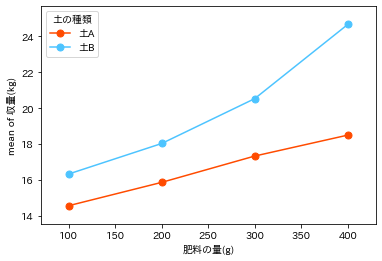

In [247]:
fig = interaction_plot(df["肥料の量(g)"], df["土の種類"], df["収量(kg)"], 
                       colors = [ '#FF4B00', '#4DC4FF'],ms=14)
plt.show()

土Bの方が肥料の量の増加につれて収量の伸びが大きいことから、  
「交互作用効果」が確認できます。

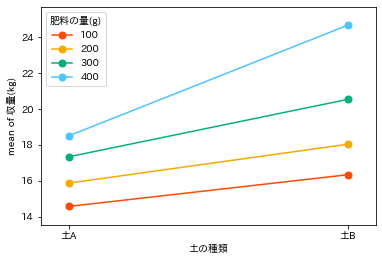

In [248]:
fig = interaction_plot(df["土の種類"], df["肥料の量(g)"], df["収量(kg)"],
                       colors = [ '#FF4B00', '#F6AA00', '#03AF7A', '#4DC4FF'], ms=14)
plt.show()

肥料の量によって土の種類に対する収量の伸びが異なることから、  
「交互作用効果」が確認できます。

ここでPythonで二次元配置分散分析を行いたいところですが、  
理想の結果が得られなかったので、省略することにします。